In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import collections
import struct

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

from construct import *

AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / ccsds.GreedyBytes
)

CLCW = BitStruct(
    'control_word_type' / Flag,
    'clcw_version_number' / BitsInteger(2),
    'status_field' / BitsInteger(3),
    'cop_in_effect' / BitsInteger(2),
    'virtual_channel_identification' / BitsInteger(6),
    'rsvd_spare' / BitsInteger(2),
    'no_rf_avail' / Flag,
    'no_bit_lock' / Flag,
    'lock_out' / Flag,
    'wait' / Flag,
    'retransmit' / Flag,
    'farm_b_counter' / BitsInteger(2),
    'rsvd_spare2' / BitsInteger(1),
    'report_value' / BitsInteger(8)
)

In [2]:
frames = np.fromfile('equl_frames.u8', 'uint8').reshape(-1, 444)
frames.shape

(591, 444)

## AOS frames

Frames are AOS frames using spacecraft ID `0x50` (assigned to [EQUULEUS in SANA registry](https://sanaregistry.org/r/spacecraftid/records/14076)). Virtual channels 1 and 63 (OID) are in use. Operation Control Field is used. OID frames in VC 63 have the OCF set to zero. The VC 1 frames in this recording have all the same OCF values.

In [3]:
aos = [ccsds.AOSPrimaryHeader.parse(f) for f in frames]
scid = np.array([a.spacecraft_id for a in aos])
vcid = np.array([a.virtual_channel_id for a in aos])
vcfc = np.array([a.virtual_channel_frame_count for a in aos])
aos[:5]

[Container(transfer_frame_version_number=1, spacecraft_id=80, virtual_channel_id=1, virtual_channel_frame_count=24905, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=80, virtual_channel_id=1, virtual_channel_frame_count=24906, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=80, virtual_channel_id=1, virtual_channel_frame_count=24907, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=80, virtual_channel_id=1, virtual_channel_frame_count=24908, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=80, virtual_channel_id=1, virtual_channel_frame_count=24909, replay_flag=False, vc_frame_count_usage_flag=

In [4]:
collections.Counter(scid)

Counter({80: 589, 35: 1, 173: 1})

In [5]:
collections.Counter(vcid)

Counter({1: 554, 63: 35, 46: 1, 24: 1})

In [6]:
collections.Counter(vcid[scid == 0x50])

Counter({1: 554, 63: 35})

In [7]:
ocf_vc1 = frames[vcid == 1, -4:]
np.all(ocf_vc1 == ocf_vc1[0])

True

In [8]:
ocf_vc63 = frames[vcid == 63, -4:]
np.all(ocf_vc63 == ocf_vc63[0])

True

In [9]:
ocf_vc63[0]

array([0, 0, 0, 0], dtype=uint8)

In [10]:
print(CLCW.parse(ocf_vc1[0]))

Container: 
    control_word_type = False
    clcw_version_number = 0
    status_field = 0
    cop_in_effect = 1
    virtual_channel_identification = 0
    rsvd_spare = 0
    no_rf_avail = False
    no_bit_lock = False
    lock_out = False
    wait = False
    retransmit = False
    farm_b_counter = 2
    rsvd_spare2 = 0
    report_value = 225


## VC 1

Virtual channel 1 uses M_PDU to transmit Space Packets. Only APID 1296 is in use. The packets have a secondary header, but their sequence count is always zero. There are packets of different sizes, and it seems that each size corresponds to a different packet type, according to their contents.

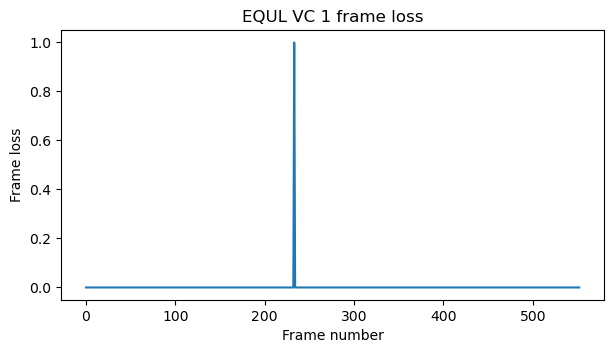

In [11]:
frame_loss_vc1 = np.diff(vcfc[vcid == 1]) - 1
plt.plot(frame_loss_vc1)
plt.title('EQUL VC 1 frame loss')
plt.xlabel('Frame number')
plt.ylabel('Frame loss');

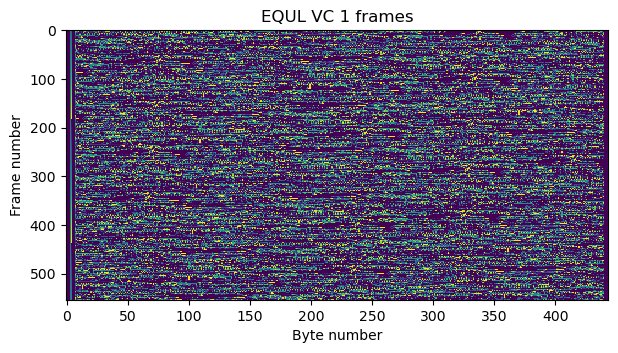

In [12]:
plt.imshow(frames[vcid == 1], aspect='auto', interpolation='none')
plt.title('EQUL VC 1 frames')
plt.ylabel('Frame number')
plt.xlabel('Byte number');

In [13]:
frames_vc1 = [AOSFrame.parse(f[:-4]) for f in frames[vcid == 1]]
packets = list(ccsds.extract_space_packets(frames_vc1, 0x50, 1))

/home/daniel/jupyter_notebooks/ArtemisI/../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 80 VC 1] Broken stream. Last frame count 25138, current frame count 25140
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')


In [14]:
packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets]
packet_headers[:4]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1296, sequence_flags=3, packet_sequence_count_or_name=0, data_length=407),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1296, sequence_flags=3, packet_sequence_count_or_name=0, data_length=337),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1296, sequence_flags=3, packet_sequence_count_or_name=0, data_length=407),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1296, sequence_flags=3, packet_sequence_count_or_name=0, data_length=413)]

In [15]:
apids = collections.Counter([p.APID for p in packet_headers])
apids

Counter({1296: 587})

In [16]:
packet_lengths = collections.Counter([len(p) for p in packets])
packet_lengths

Counter({414: 294, 344: 30, 420: 147, 431: 30, 382: 28, 302: 29, 422: 29})

In [17]:
by_len = {length: [p for p in packets if len(p) == length]
          for length in packet_lengths}

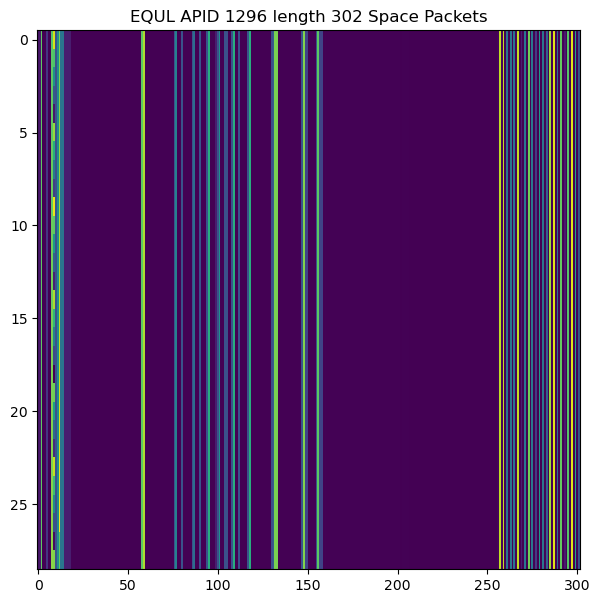

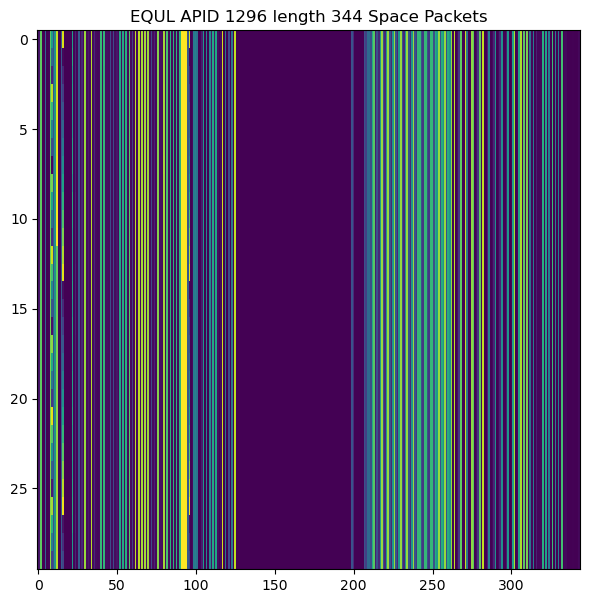

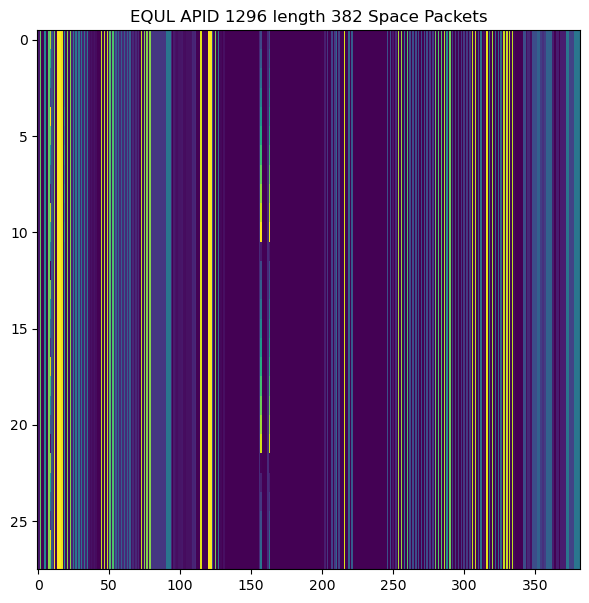

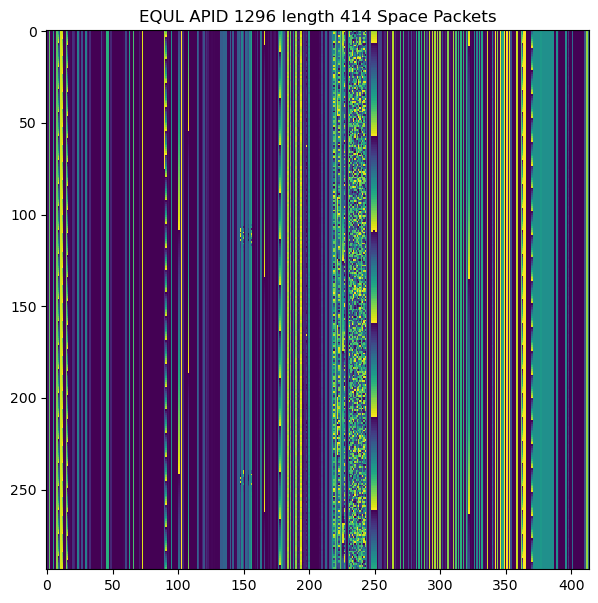

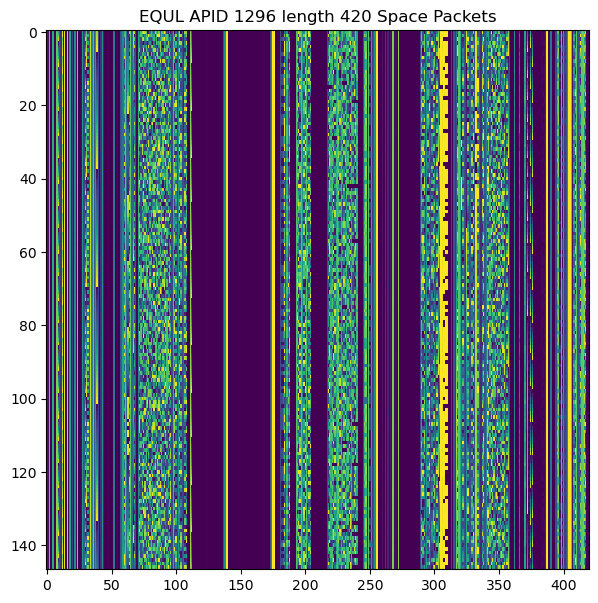

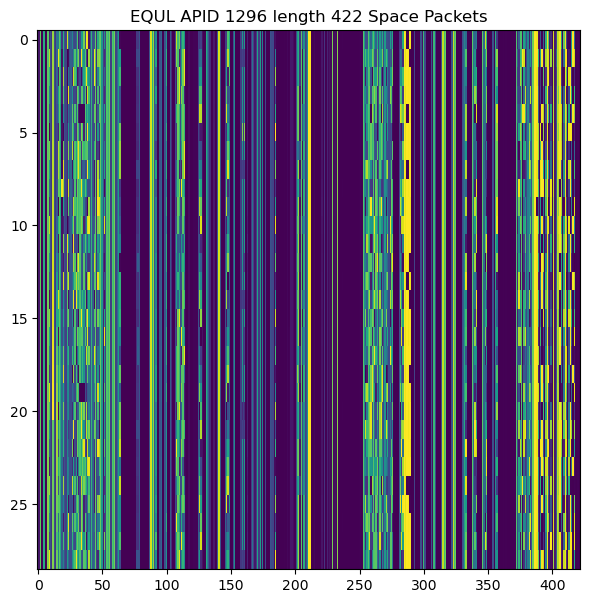

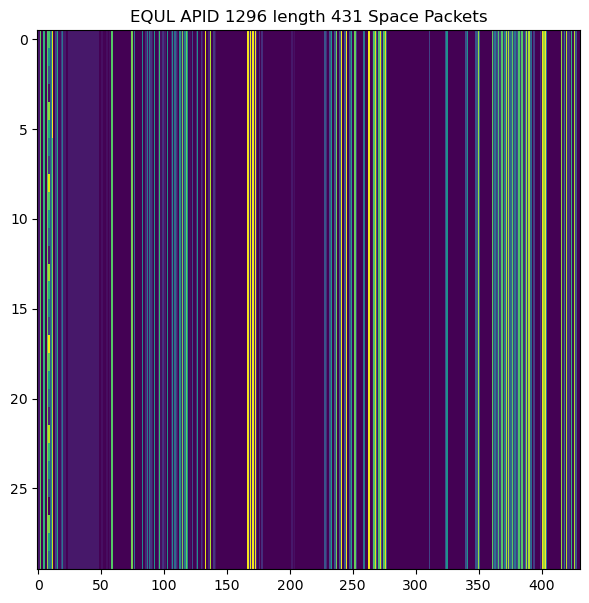

In [18]:
for length in sorted(by_len):
    plt.figure(figsize=(7, 7))
    plt.imshow(np.array([np.frombuffer(a, 'uint8') for a in by_len[length]]),
               aspect='auto', interpolation='None')
    plt.title(f'EQUL APID 1296 length {length} Space Packets')

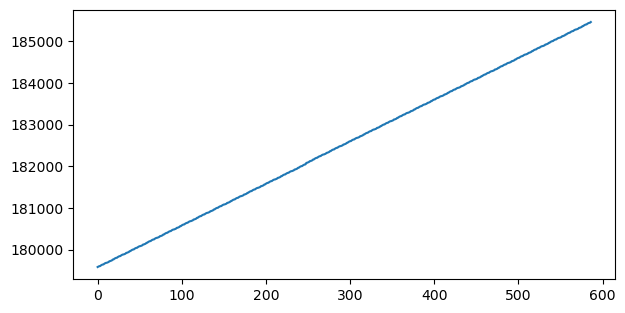

In [19]:
timestamps = np.array([struct.unpack('>I', p[6:10])[0] for p in packets])
plt.plot(timestamps)

In [20]:
(timestamps[-1] - timestamps[0]) / 10

588.0

In [21]:
timestamps[0] / 10 / 3600

4.988444444444445

In [22]:
np.datetime64('2022-11-16T15:26:59') - np.timedelta64(1, 's') * (timestamps[0] / 10)

numpy.datetime64('2022-11-16T10:27:41')

## VC 63

Idle frames in VC 63 contain `0x07fe` after the AOS primary header. This is most likely an M_PDU header indicating that the packet zone contains only idle data. The packet zone is filled with 20 `0x88` bytes followed by a pattern that involves `0x00`, `0x0c`, `0xc0` and `0xcc`. 

In [23]:
[a for a in aos if a.virtual_channel_id == 63][:5]

[Container(transfer_frame_version_number=1, spacecraft_id=80, virtual_channel_id=63, virtual_channel_frame_count=0, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=80, virtual_channel_id=63, virtual_channel_frame_count=0, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=80, virtual_channel_id=63, virtual_channel_frame_count=0, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=80, virtual_channel_id=63, virtual_channel_frame_count=0, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=80, virtual_channel_id=63, virtual_channel_frame_count=0, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spa

In [24]:
np.all(frames[vcid == 63][0] == frames[vcid == 63])

True

In [25]:
ccsds.M_PDU_Header.parse(frames[vcid == 63][0][ccsds.AOSPrimaryHeader.sizeof():])

Container(rsv_spare=0, first_header_pointer=2046)

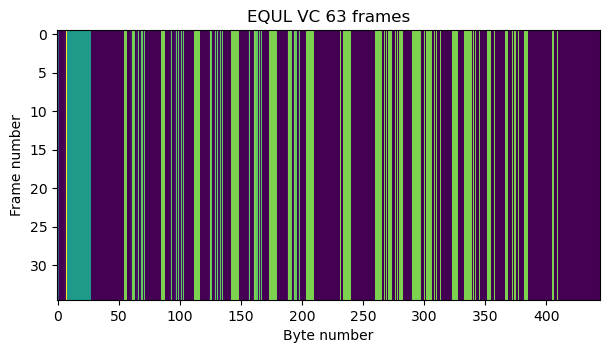

In [26]:
plt.figure()
plt.imshow(frames[vcid == 63], aspect='auto', interpolation='none')
plt.title('EQUL VC 63 frames')
plt.ylabel('Frame number')
plt.xlabel('Byte number');

In [27]:
frames[vcid == 63][0][8:]

array([136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136,
       136, 136, 136, 136, 136, 136, 136,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 204, 204,   0,   0,   0,
        12, 204, 204, 192,   0,  12, 192,   0,  12, 192,  12, 192,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 204,
       204, 204,   0,   0,   0,   0,  12, 192,   0,   0,  12, 192,  12,
       192,  12, 192,  12, 192,   0,   0,   0,   0,   0,   0,   0,   0,
       204, 204, 204, 204, 204,   0,   0,   0,   0,   0,   0,   0,  12,
       204, 192,   0,  12, 192,  12, 192,  12, 192,  12, 192,   0,   0,
         0,   0,   0,   0, 204, 204, 204, 204, 204, 204, 204,   0,   0,
         0,   0,   0,   0,   0,  12, 192,   0,   0,  12, 204, 204, 192,
        12, 192,  12, 192,   0,   0,   0,   0,   0, 204, 204, 204, 204,
       204, 204, 204,   0,   0,   0,   0,   0,   0,   0,   0,  1

In [28]:
[hex(a) for a in set(frames[vcid == 63][0][8:])]

['0x0', '0xc0', '0x88', '0xcc', '0xc']